In [1]:
import datetime
import json
import boto3
import io
import pickle
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
#import seaborn as sns
plt.style.use('ggplot')

In [2]:
DF_COLUMNS = [
    "datetime",
    "cash",
    "cash_orig",
    "btc_in_possession",
    "btc_current_price",
    "position",
    "rate_of_change",
    "total_value",
    "acceleration",
    "bid_high",
    "ask_low",
    "mid_price",
    "bought_price",
    "sold_price",
    "ask_price",
    "target_profit",
    "size"
]
BUCKET_NAME = 'btc-autotrader-log'
DATE = '2020-03-16'

In [3]:
session = boto3.session.Session(profile_name='default')
s3 = session.client('s3')

In [4]:
list_objects_response = s3.list_objects(
    Bucket=BUCKET_NAME,
    Prefix=DATE
)

keys = []
for l in list_objects_response['Contents']:
    keys.append(l['Key'])

In [5]:
merged = pd.DataFrame(columns=DF_COLUMNS)

for k in keys:
    obj = s3.get_object(
        Bucket=BUCKET_NAME,
        Key=k
    )
    o = obj['Body'].read()
    #merged = pd.merge(merged, pickle.loads(o))
    merged = merged.append(pickle.loads(o))

In [6]:
df = merged

In [7]:
df.head()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,ask_low,mid_price,bought_price,sold_price,ask_price,target_profit,size
0,2020-03-16 00:00:52.228669,0.0,0,0.0,582250.0,0,-5.203649,0,-0.041636,582000.0,582238.0,582119.0,0.0,0.0,0.0,0,0
0,2020-03-16 00:00:57.276475,0.0,0,0.0,582000.0,0,-5.562194,0,-0.070733,581580.0,581949.0,581764.0,0.0,0.0,0.0,0,0
0,2020-03-16 00:01:02.327997,0.0,0,0.0,581329.0,0,-6.841925,0,-0.252405,581311.0,581528.0,581419.0,0.0,0.0,0.0,0,0
0,2020-03-16 00:01:07.381610,0.0,0,0.0,581318.0,0,-8.233107,0,-0.274464,580580.0,581631.0,581105.0,0.0,0.0,0.0,0,0
0,2020-03-16 00:01:12.432531,0.0,0,0.0,581610.0,0,-9.881895,0,-0.325326,580273.0,581205.0,580739.0,0.0,0.0,0.0,0,0


In [8]:
df['spread'] = df.ask_low - df.bid_high

In [9]:
df['spread_pct_change'] = df.spread.pct_change()

In [10]:
df.loc[df.rate_of_change >= 0, 'rate_of_change_positive'] = 1
df.loc[df.rate_of_change < 0, 'rate_of_change_positive'] = -1
df.loc[df.rate_of_change >= 5, 'rate_of_change_positive'] = 2
df.loc[df.rate_of_change < -5, 'rate_of_change_positive'] = -2

In [11]:
df['btc_current_price_normalized'] = (df.btc_current_price - df.btc_current_price.mean()) / df.btc_current_price.std()


In [12]:
df['returns'] = np.log(df['btc_current_price']/df['btc_current_price'].shift(1))

/Users/soichi/.pyenv/versions/3.7.1/envs/finance-stats/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [13]:
df['strategy'] = df['rate_of_change_positive'].shift(1) * df['returns']

In [14]:
df.tail()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,sold_price,ask_price,target_profit,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2020-03-17 00:00:19.588214,0.0,0,0.0,549310.0,0,14.304263,0,0.000000,549009.0,...,0.0,0.0,0,0,301.0,0.157692,2.0,0.010493,0.002959,0.005918
0,2020-03-17 00:00:24.637806,0.0,0,0.0,549880.0,0,48.992186,0,6.842295,549310.0,...,0.0,0.0,0,0,570.0,0.893688,2.0,0.042077,0.001037,0.002074
0,2020-03-17 00:00:29.688220,0.0,0,0.0,549880.0,0,81.757614,0,6.460421,548000.0,...,0.0,0.0,0,0,1000.0,0.754386,2.0,0.042077,0.000000,0.000000
0,2020-03-17 00:00:34.737960,0.0,0,0.0,549878.0,0,81.757614,0,0.000000,549076.0,...,0.0,0.0,0,0,800.0,-0.200000,2.0,0.041966,-0.000004,-0.000007
0,2020-03-17 00:00:39.788844,0.0,0,0.0,549003.0,0,46.707798,0,-6.916315,548628.0,...,0.0,0.0,0,0,507.0,-0.366250,2.0,-0.006518,-0.001593,-0.003185


In [15]:
np.exp(df[['returns', 'strategy']].sum())

returns     NaN
strategy    inf
dtype: float64

/Users/soichi/.pyenv/versions/3.7.1/envs/finance-stats/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


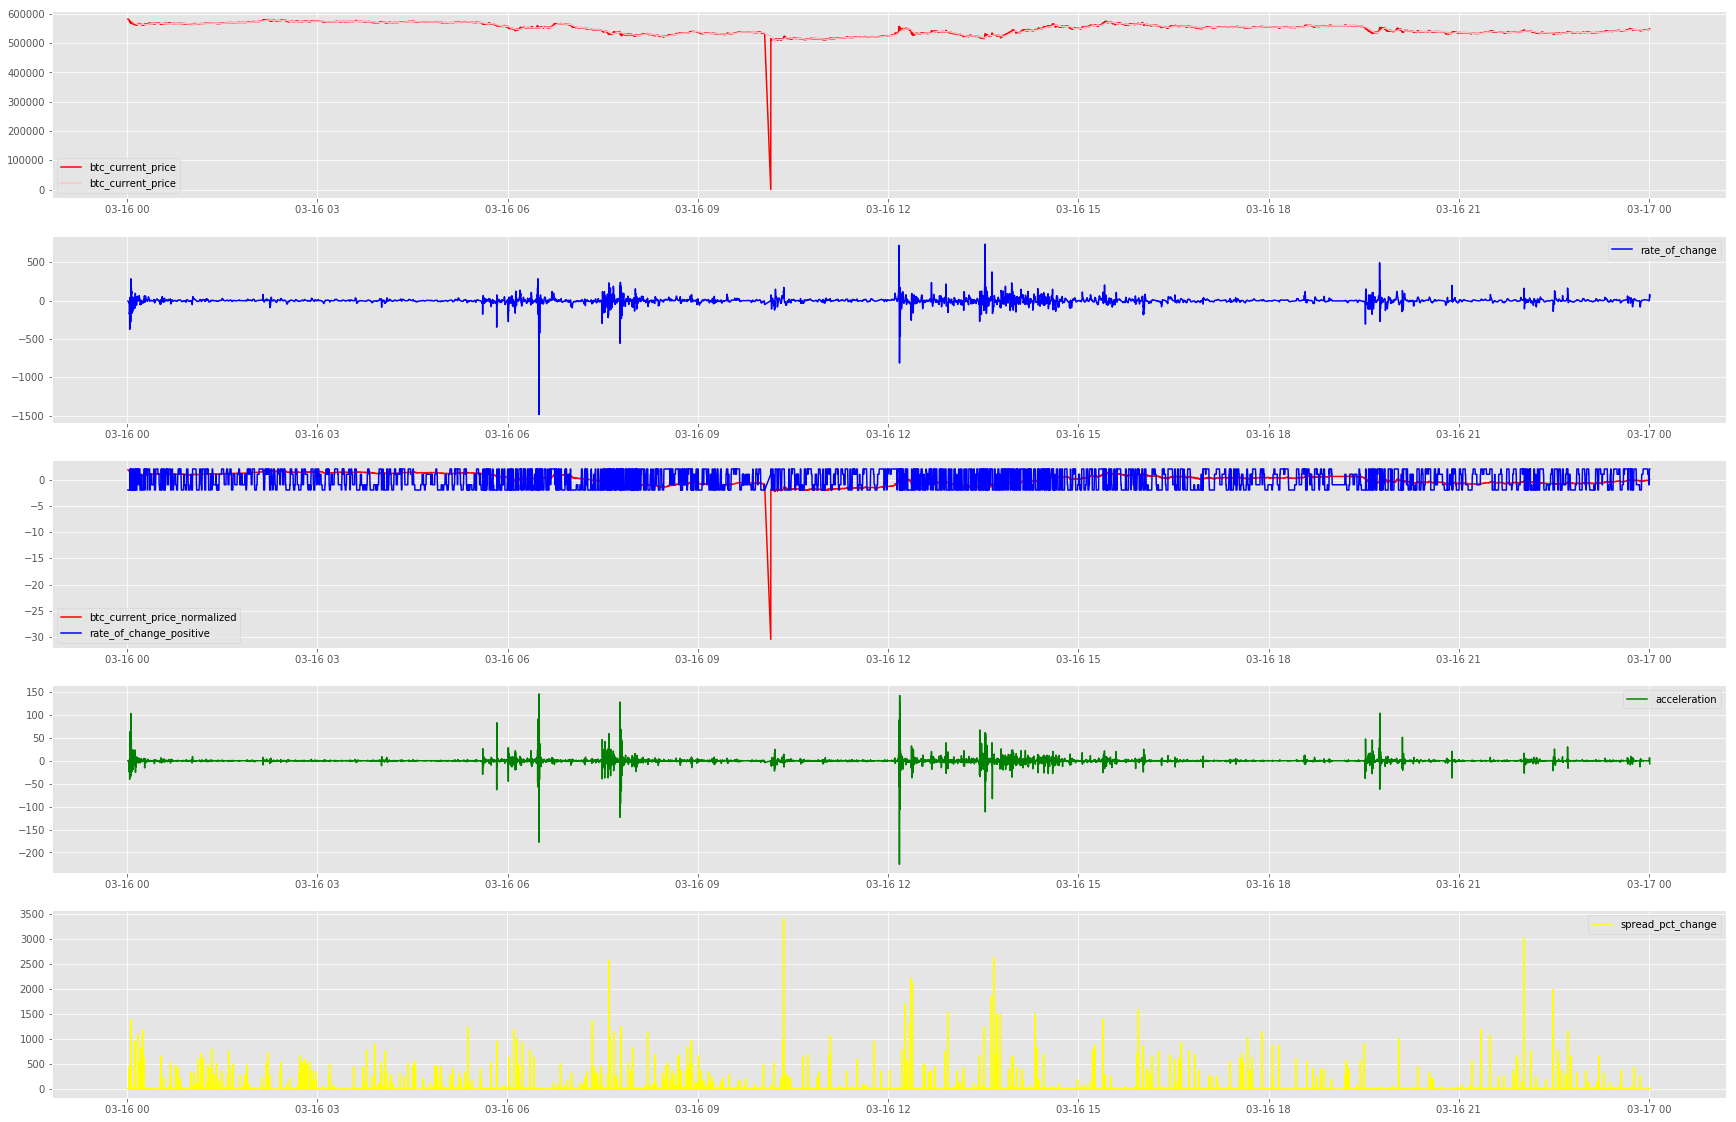

In [16]:
num = 5
fig, axes = plt.subplots(nrows=num, ncols=1, figsize=(30, 20), sharex=True)
plt.subplot(num,1,1)
plt.plot(df.datetime, df.btc_current_price, color='r')
plt.plot(df.datetime, df.btc_current_price.rolling(50).mean(), color='pink')
plt.legend()
#ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
#ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
plt.subplot(num,1,2)
plt.plot(df.datetime, df.rate_of_change, color='b')
plt.legend()
plt.subplot(num,1,3)
plt.plot(df.datetime, df.btc_current_price_normalized, color='r')
plt.plot(df.datetime, df.rate_of_change_positive, color='b')
plt.legend()
plt.subplot(num,1,4)
plt.plot(df.datetime, df.acceleration, color='g')
#plt.yscale('log')
plt.legend()
plt.subplot(num,1,5)
plt.plot(df.datetime, df.spread_pct_change, color='yellow')
plt.legend()
#plt.plot(df.datetime, df.spread_pct_change())
plt.show()

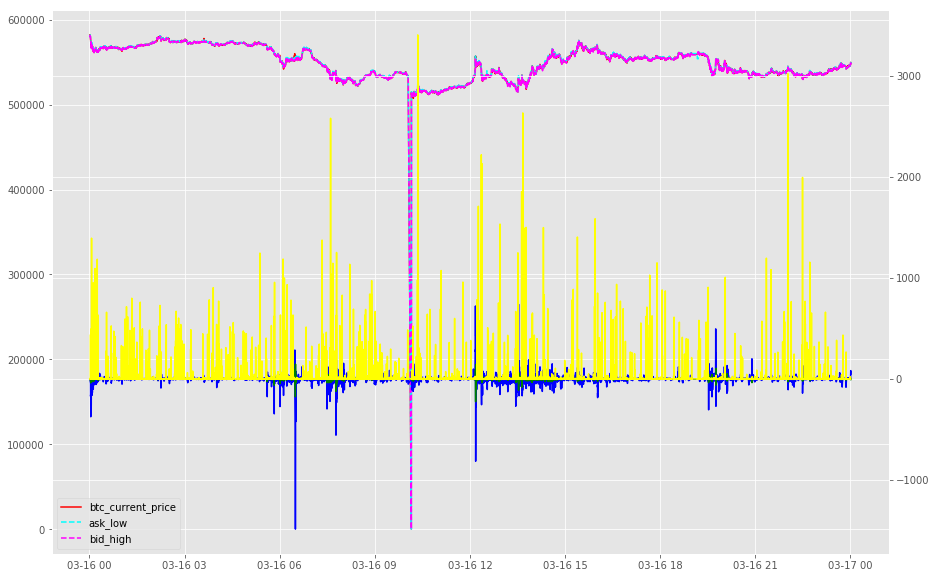

In [17]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.btc_current_price, color='r')
ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
ax1.legend()
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
#ax2.legend()
plt.show()

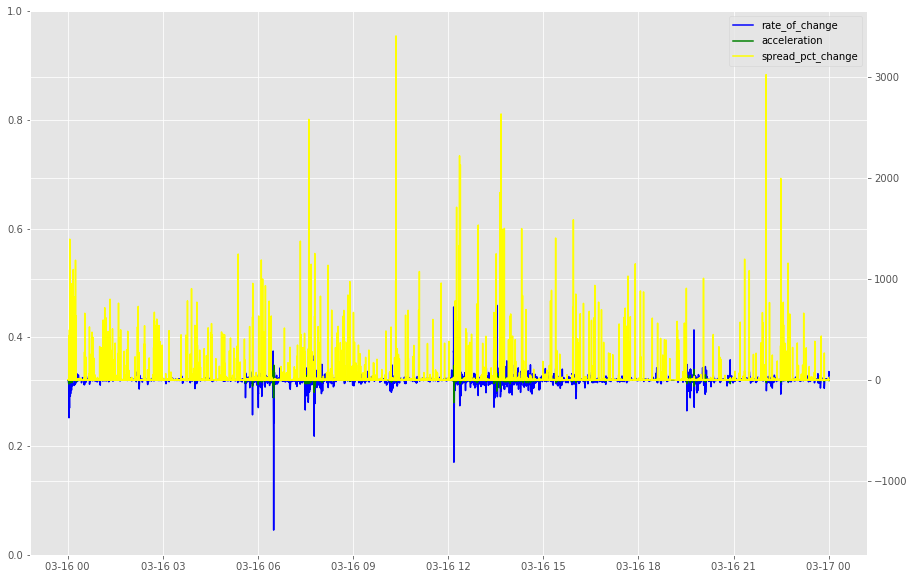

In [18]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
#ax1.plot(df.datetime, df.btc_current_price, color='r')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
ax2.legend()
plt.show()

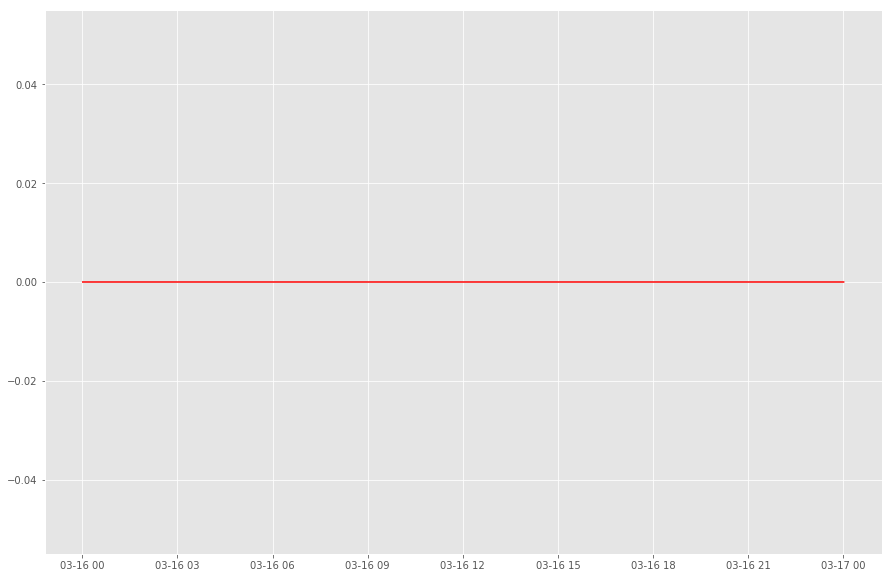

In [19]:
df_cash = df[df.position == 0]
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(df_cash.datetime, df_cash.cash, color='r')

In [20]:
df

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,sold_price,ask_price,target_profit,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2020-03-16 00:00:52.228669,0.0,0,0.0,582250.0,0,-5.203649,0,-0.041636,582000.0,...,0.0,0.0,0,0,238.0,NaN,-2.0,1.835694,NaN,NaN
0,2020-03-16 00:00:57.276475,0.0,0,0.0,582000.0,0,-5.562194,0,-0.070733,581580.0,...,0.0,0.0,0,0,369.0,0.550420,-2.0,1.821842,-0.000429,0.000859
0,2020-03-16 00:01:02.327997,0.0,0,0.0,581329.0,0,-6.841925,0,-0.252405,581311.0,...,0.0,0.0,0,0,217.0,-0.411924,-2.0,1.784662,-0.001154,0.002307
0,2020-03-16 00:01:07.381610,0.0,0,0.0,581318.0,0,-8.233107,0,-0.274464,580580.0,...,0.0,0.0,0,0,1051.0,3.843318,-2.0,1.784052,-0.000019,0.000038
0,2020-03-16 00:01:12.432531,0.0,0,0.0,581610.0,0,-9.881895,0,-0.325326,580273.0,...,0.0,0.0,0,0,932.0,-0.113225,-2.0,1.800232,0.000502,-0.001004
0,2020-03-16 00:01:17.481960,0.0,0,0.0,580550.0,0,-12.195920,0,-0.457272,580520.0,...,0.0,0.0,0,0,510.0,-0.452790,-2.0,1.741497,-0.001824,0.003648
0,2020-03-16 00:01:22.533899,0.0,0,0.0,581197.0,0,-15.252627,0,-0.601697,580224.0,...,0.0,0.0,0,0,875.0,0.715686,-2.0,1.777348,0.001114,-0.002228
0,2020-03-16 00:01:27.582053,0.0,0,0.0,580937.0,0,-16.118518,0,-0.170852,580224.0,...,0.0,0.0,0,0,875.0,0.000000,-2.0,1.762941,-0.000447,0.000895
0,2020-03-16 00:01:32.626906,0.0,0,0.0,580599.0,0,-24.565819,0,-1.666730,580580.0,...,0.0,0.0,0,0,1524.0,0.741714,-2.0,1.744213,-0.000582,0.001164
0,2020-03-16 00:01:37.678082,0.0,0,0.0,580598.0,0,-25.727689,0,-0.229402,580226.0,...,0.0,0.0,0,0,372.0,-0.755906,-2.0,1.744157,-0.000002,0.000003
